In [2]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [6]:
# Only rescale validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [8]:
# Load data from split_data directory
try:
    train_generator = train_datagen.flow_from_directory(
        'split_data/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    validation_generator = val_test_datagen.flow_from_directory(
        'split_data/val',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        'split_data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print("Data generators created successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    raise


Found 16299 images belonging to 16 classes.
Found 2033 images belonging to 16 classes.
Found 2050 images belonging to 16 classes.
Data generators created successfully!


In [9]:
# Load MobileNetV2 pre-trained model
try:
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    print("MobileNetV2 loaded successfully!")
except Exception as e:
    print(f"Error loading MobileNetV2: {e}")
    raise


MobileNetV2 loaded successfully!


In [ ]:
# Freeze the base model
base_model.trainable = False


In [ ]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create and compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
# Define checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [ ]:
# Train the model
EPOCHS = 10
try:
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[checkpoint]
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise


Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.7738
Epoch 1: val_accuracy improved from -inf to 0.85981, saving model to best_model.h5
510/510 [==============================] - 576s 1s/step - loss: 0.7037 - accuracy: 0.7738 - val_loss: 0.4246 - val_accuracy: 0.8598
Epoch 2/10
510/510 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8631
Epoch 2: val_accuracy did not improve from 0.85981
510/510 [==============================] - 401s 786ms/step - loss: 0.4103 - accuracy: 0.8631 - val_loss: 0.4484 - val_accuracy: 0.8392
Epoch 3/10
510/510 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8815
Epoch 3: val_accuracy improved from 0.85981 to 0.87703, saving model to best_model.h5
510/510 [==============================] - 402s 787ms/step - loss: 0.3497 - accuracy: 0.8815 - val_loss: 0.3715 - val_accuracy: 0.8770
Epoch 4/10
510/510 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0

In [ ]:
# Evaluate on test data
best_model = tf.keras.models.load_model('best_model.h5')
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


65/65 [==============================] - 54s 812ms/step - loss: 0.2782 - accuracy: 0.9078
Test Accuracy: 0.9078, Test Loss: 0.2782


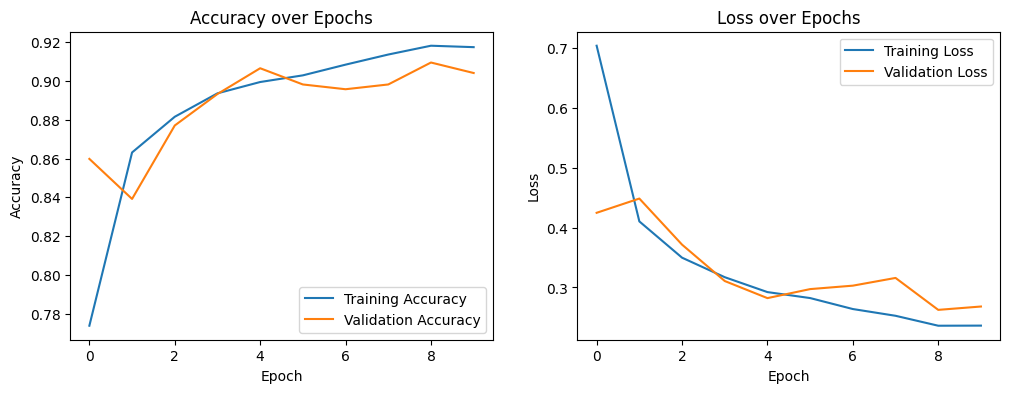

In [ ]:
# Visualize training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Fine-Tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:  # Adjust for VGG16 if used
    layer.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[ModelCheckpoint('best_model_fine.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)]
)


Epoch 1/5
510/510 [==============================] - ETA: 0s - loss: 0.9673 - accuracy: 0.7427
Epoch 1: val_accuracy improved from -inf to 0.89720, saving model to best_model_fine.h5
510/510 [==============================] - 613s 1s/step - loss: 0.9673 - accuracy: 0.7427 - val_loss: 0.3217 - val_accuracy: 0.8972
Epoch 2/5
510/510 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.8664
Epoch 2: val_accuracy improved from 0.89720 to 0.89818, saving model to best_model_fine.h5
510/510 [==============================] - 591s 1s/step - loss: 0.3990 - accuracy: 0.8664 - val_loss: 0.3121 - val_accuracy: 0.8982
Epoch 3/5
510/510 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8936
Epoch 3: val_accuracy improved from 0.89818 to 0.90605, saving model to best_model_fine.h5
510/510 [==============================] - 590s 1s/step - loss: 0.3078 - accuracy: 0.8936 - val_loss: 0.2893 - val_accuracy: 0.9061
Epoch 4/5
510/510 [==============================

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image


In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf


In [ ]:
# Define image size (must match training)
IMG_SIZE = (224, 224)


In [ ]:
# Load and preprocess a new image
img_path = 'split_data/test/Tomato_healthy/0e1d7722-3df9-4a3a-a4e2-bc0ea3ce0da4___RS_HL 9979.JPG'
try:
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
except FileNotFoundError:
    print(f"Error: Image not found at {img_path}. Please provide a valid image path.")
    raise


In [ ]:
# Load the trained model
model_path = 'best_model_fine.h5'  # Or best_model_vgg16_fine.h5 if fine-tuned
try:
    best_model = tf.keras.models.load_model(model_path)
except Exception as e:
    print(f"Error loading model: {e}")
    raise


In [ ]:
# Make prediction
predictions = best_model.predict(img_array)
predicted_class_idx = np.argmax(predictions[0])


1/1 [==============================] - 1s 1s/step


In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('best_model_fine.h5')

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
import os

train_dir = 'split_data/train'
class_labels = sorted(os.listdir(train_dir))
print(f"Number of classes: {len(class_labels)}")
print(f"Class labels: {class_labels}")


Number of classes: 16
Class labels: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf


In [ ]:
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

# Define image size
IMG_SIZE = (224, 224)


In [34]:
# Get class labels from dataset
train_dir = 'split_data/train'  # Update path if needed
class_labels = sorted(os.listdir(train_dir))
print(f"Number of classes: {len(class_labels)}")
print(f"Class labels: {class_labels}")


Number of classes: 16
Class labels: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'PlantVillage', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
img_path = 'split_data/test/Tomato_healthy/0e1d7722-3df9-4a3a-a4e2-bc0ea3ce0da4___RS_HL 9979.JPG'  # Update with real path
try:
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
except FileNotFoundError:
    print(f"Error: Image not found at {img_path}. Please provide a valid image path.")
    raise


In [ ]:
# Load the trained model
model_path = 'best_model_fine.h5'
try:
    best_model = tf.keras.models.load_model(model_path)
except Exception as e:
    print(f"Error loading model: {e}")
    raise


In [37]:
# Verify model output classes
model_output_classes = best_model.layers[-1].units
if model_output_classes != len(class_labels):
    print(f"Warning: Model expects {model_output_classes} classes, but dataset has {len(class_labels)} classes.")
    raise ValueError("Class mismatch between model and dataset")


In [ ]:
# Make prediction
predictions = best_model.predict(img_array)
predicted_class_idx = np.argmax(predictions[0])
print(f"Predicted index: {predicted_class_idx}")


1/1 [==============================] - 1s 1s/step
Predicted index: 15


In [ ]:
# Get predicted class
predicted_class = class_labels[predicted_class_idx]
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probabilities: {predictions[0]}")


Predicted Class: Tomato_healthy
Prediction Probabilities: [3.2307162e-07 3.5801561e-06 1.1620171e-10 4.6137512e-09 3.5066025e-10
 2.8834105e-08 5.7734486e-12 3.0834577e-04 1.4695469e-06 4.1416646e-07
 3.4819354e-07 3.8278871e-04 5.9686634e-03 8.6338554e-09 2.9763418e-08
 9.9333400e-01]
